In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import re

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 2022
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = pd.read_csv('../input/sberbank/train_aug.csv', index_col=0)
test_data = pd.read_csv('../input/sberbank/test_data.csv', index_col='id')

In [3]:
test_data.drop('Unnamed: 0', inplace=True, axis=1)
test_data.fillna('', inplace=True)
test_data['titletext'] = test_data['title'] + ". " + test_data['text']

In [4]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

In [5]:
train, val = train_test_split(train_data, test_size=0.2, random_state=2022, shuffle=True)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [6]:
class Tokenisation(Dataset):
    
    
    def __init__(self, data, targets, tokenizer, max_len):
        self.data = data
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_vid = self.tokenizer.vocab["[PAD]"]
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        data = str(self.data[item])
        data = " ".join(data.split())
        target = self.targets
        
        encoding = self.tokenizer.encode_plus(
          data,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )
        
        ids = encoding['input_ids']
        masks = encoding['attention_mask']
        token_type_ids = encoding['input_ids']
        
        true_seq_length = len(encoding['input_ids'][0])
        pad_size = self.max_len - true_seq_length
        pad_ids = torch.Tensor([self.pad_vid] * pad_size).long()
        ids = torch.cat((encoding['input_ids'][0], pad_ids))
        
        
#         padding_len = self.max_len - len(ids)
#         ids = ids + ([0] * padding_len)
#         masks = ids + ([0] * padding_len)
#         token_type_ids = token_type_ids + ([0] * padding_len)
        
        return {
          'text': data,
          'input_ids': ids.flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target[item], dtype=torch.long)
        }

In [7]:
def CustomLoader(df, tokenizer, max_len, batch_size):
    ds = Tokenisation(
    data=df['sentence'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader(ds,batch_size=batch_size, num_workers=2)

In [8]:
BATCH_SIZE = 32
MAX_LEN = 115

train_loader = CustomLoader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = CustomLoader(val, tokenizer, MAX_LEN, BATCH_SIZE)

In [9]:
class TextClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(TextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
            
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)
    
    def unfreeze(self,start_layer,end_layer):
        def children(m):
            return m if isinstance(m, (list, tuple)) else list(m.children())
        def set_trainable_attr(m, b):
            m.trainable = b
            for p in m.parameters():
                p.requires_grad = b
        def apply_leaf(m, f):
            c = children(m)
            if isinstance(m, nn.Module):
                f(m)
            if len(c) > 0:
                for l in c:
                    apply_leaf(l, f)
        def set_trainable(l, b):
            apply_leaf(l, lambda m: set_trainable_attr(m, b))

        # You can unfreeze the last layer of bert by calling set_trainable(model.bert.encoder.layer[23], True)
        set_trainable(self.bert, False)
        for i in range(start_layer, end_layer+1):
            set_trainable(self.bert.encoder.layer[i], True)

In [10]:
model = TextClassifier(len(train_data['label'].unique()))
model = model.to(device)

In [11]:
EPOCHS = 20
MAX_LENGTH = 115
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8

LearningRate = 3e-5

BETAS = (0.9, 0.999)
BERT_WEIGHT_DECAY = 0.01
EPS = 1e-8
 
bert_identifiers = ['embedding', 'encoder', 'pooler']
no_weight_decay_identifiers = ['bias', 'LayerNorm.weight']
grouped_model_parameters = [
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    not any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': BERT_WEIGHT_DECAY,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if not any(identifier in name for identifier in bert_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS}
]


optimizers = AdamW(grouped_model_parameters)

optimizer = AdamW(model.parameters(), lr=4e-5, correct_bias=False)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [12]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [13]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    
    losses = []
    
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [14]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
                                        model,
                                        train_loader,
                                        loss_fn,
                                        optimizer,
                                        device,
                                        scheduler,
                                        len(train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
                                    model,
                                    val_loader,
                                    loss_fn,
                                    device,
                                    len(val)
  )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)   
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.pt')
        best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.6081426858901977 accuracy 0.7121401752190238


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.5709456021969135 accuracy 0.7425

Epoch 2/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.5490449619293213 accuracy 0.7734668335419275


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 1.1309466453698964 accuracy 0.365

Epoch 3/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.7122025072574616 accuracy 0.5832290362953693


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.8145308769666232 accuracy 0.3875

Epoch 4/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.6488977122306824 accuracy 0.6195244055068836


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.6568187291805561 accuracy 0.73

Epoch 5/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.6024618548154831 accuracy 0.6620775969962454


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.6002114736116849 accuracy 0.5725

Epoch 6/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.5286343884468079 accuracy 0.7115143929912391


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.5284340633795812 accuracy 0.785

Epoch 7/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.44533310174942015 accuracy 0.8210262828535669


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4712630281081566 accuracy 0.7775

Epoch 8/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.38249395668506625 accuracy 0.846683354192741


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.39821895498495835 accuracy 0.8200000000000001

Epoch 9/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.3276929335296154 accuracy 0.8773466833541927


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.3927734511402937 accuracy 0.8375

Epoch 10/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.2554395626485348 accuracy 0.9130162703379224


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4341918235787979 accuracy 0.835

Epoch 11/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.2150508227944374 accuracy 0.9286608260325407


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4476203597508944 accuracy 0.8375

Epoch 12/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.20221089031547307 accuracy 0.9443053817271589


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4694605309229631 accuracy 0.8250000000000001

Epoch 13/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.19130716063082218 accuracy 0.9505632040050063


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4206249415874481 accuracy 0.8575

Epoch 14/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.15861010000109674 accuracy 0.9580725907384231


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4314488126681401 accuracy 0.8475

Epoch 15/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.14163867097347974 accuracy 0.9618272841051314


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.46305932906957775 accuracy 0.8475

Epoch 16/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.12456195037811994 accuracy 0.9668335419274093


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4148140228711642 accuracy 0.8625

Epoch 17/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.10903732283040882 accuracy 0.9718397997496871


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4469987681278816 accuracy 0.85

Epoch 18/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.09932755487039685 accuracy 0.9762202753441802


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4597766204522206 accuracy 0.85

Epoch 19/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.09667116155847907 accuracy 0.9780976220275345


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4693331363109442 accuracy 0.865

Epoch 20/20
----------


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Train loss 0.08342228693887592 accuracy 0.9806007509386734


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length 

Val   loss 0.4560474959703592 accuracy 0.86

CPU times: user 6min 39s, sys: 15.9 s, total: 6min 55s
Wall time: 7min 17s


In [15]:
train_acc, val_acc = [], []
for i in range(10):
  train_acc.append(history['train_acc'][i].cpu().item())
  val_acc.append(history['val_acc'][i].cpu().item())

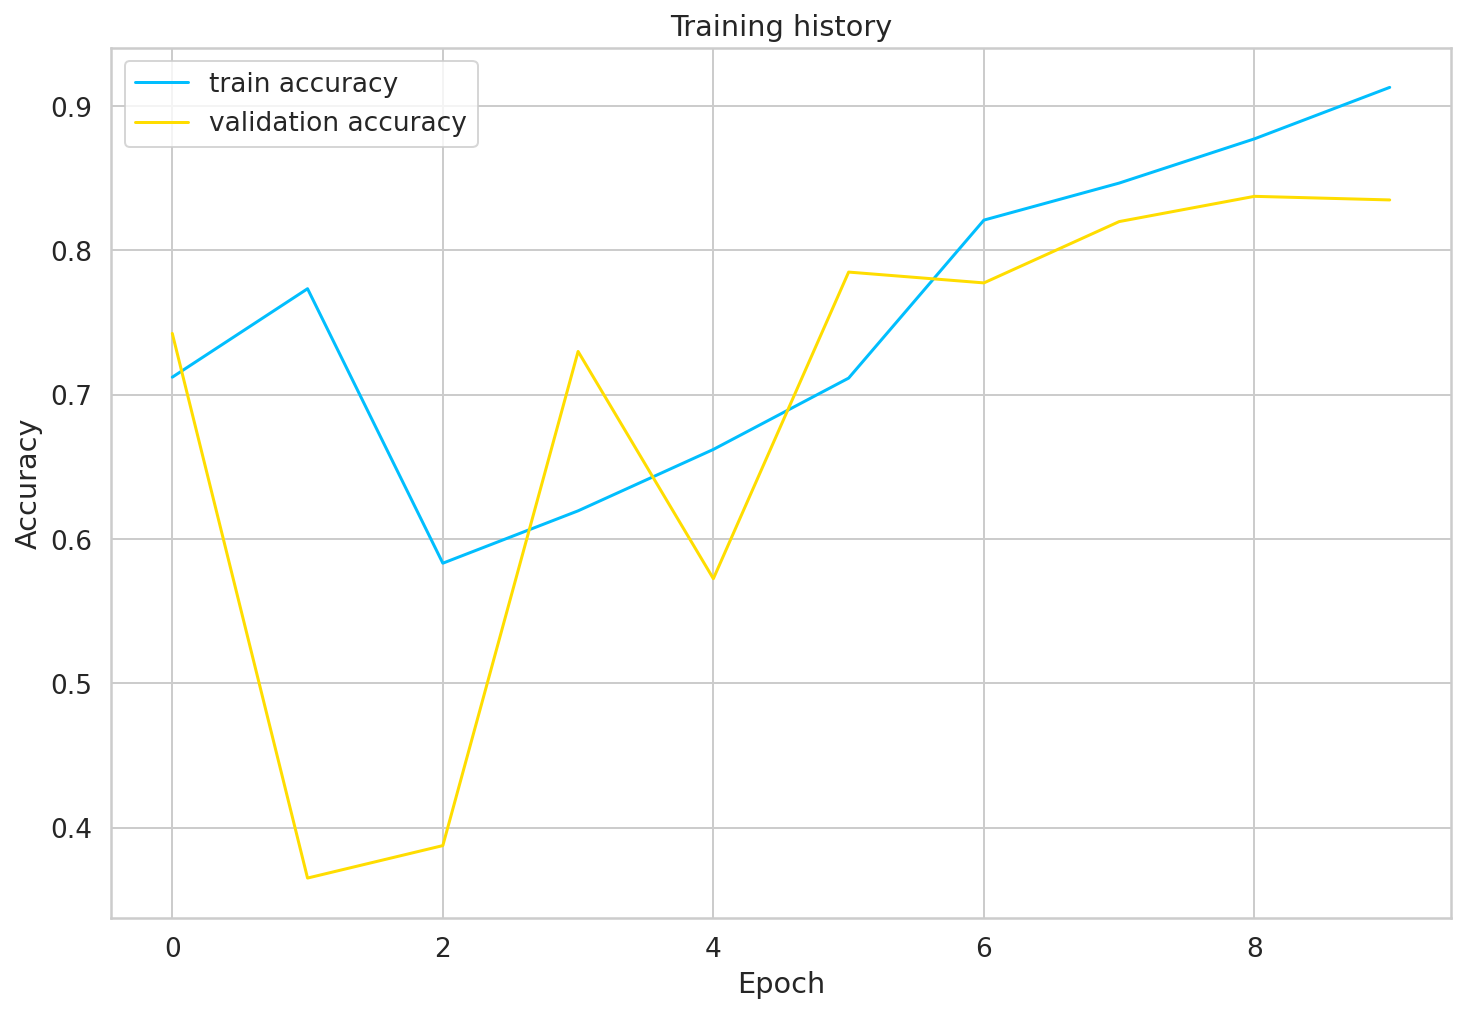

In [16]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

Сделаем два предсказания: только для текста новостей и для текста+названия.

Некоторые предложения в тестовой части имеют длину большую чем 512 слов (именно такой максимум токенов может принимать на вход берт), поэтому используем вспомогательные функции для токенизации тестовой части. Суть заключается в том, чтобы разбить длинное предложение на несколько минибатчей по 512 токенов каждый. Во время предсказания за финальнальный результат этих минибатчей принимаем наибольшую вероятность.

In [17]:
def tokenize_all_text(text, tokenizer):
    tokens = tokenizer.encode_plus(text, add_special_tokens=False,
                                   return_tensors='pt')
    return tokens


def split_overlapping(array, size, step, minimal_length):
    result = [array[i:i + size] for i in range(0, len(array), step)]
    if len(result) > 1:
        result = [x for x in result if len(x) >= minimal_length]
    return result


def split_tokens_into_smaller_chunks(tokens, size, step, minimal_length):
    assert size <= 510
    input_id_chunks = split_overlapping(
        tokens['input_ids'][0], size, step, minimal_length)
    mask_chunks = split_overlapping(
        tokens['attention_mask'][0], size, step, minimal_length)
    return input_id_chunks, mask_chunks


def add_special_tokens_at_beginning_and_end(input_id_chunks, mask_chunks):
    for i in range(len(input_id_chunks)):
        input_id_chunks[i] = torch.cat(
            [torch.Tensor([101]), input_id_chunks[i], torch.Tensor([102])])
        mask_chunks[i] = torch.cat(
            [torch.Tensor([1]), mask_chunks[i], torch.Tensor([1])])


def add_padding_tokens(input_id_chunks, mask_chunks):
    for i in range(len(input_id_chunks)):
        pad_len = 512 - input_id_chunks[i].shape[0]
        if pad_len > 0:
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_len)
            ])
            mask_chunks[i] = torch.cat([
                mask_chunks[i], torch.Tensor([0] * pad_len)
            ])


def stack_tokens_from_all_chunks(input_id_chunks, mask_chunks):
    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)
    return input_ids.long(), attention_mask.int()


def transform_text_to_model_input(
        text,
        tokenizer,
        size=510,
        step=510,
        minimal_length=100):
    tokens = tokenize_all_text(text, tokenizer)
    input_id_chunks, mask_chunks = split_tokens_into_smaller_chunks(
        tokens, size, step, minimal_length)
    add_special_tokens_at_beginning_and_end(input_id_chunks, mask_chunks)
    add_padding_tokens(input_id_chunks, mask_chunks)
    input_ids, attention_mask = stack_tokens_from_all_chunks(
        input_id_chunks, mask_chunks)
    return [input_ids, attention_mask]

In [18]:
test_data_tokenized = []
for row in test_data['titletext']:
    test_data_tokenized.append(transform_text_to_model_input(row, tokenizer))

In [19]:
pred_batch_size = 341
preds_total = []

for i in tqdm(range(len(test_data_tokenized))):
    seq = test_data_tokenized[i][0].to(device)
    mask = test_data_tokenized[i][1].to(device)

    with torch.no_grad():
        preds = F.softmax(model(seq, mask), dim=1)
        prob = preds[0][1]
    prob = prob.cpu().numpy()
    preds_total.append(prob)
    
    del preds
    torch.cuda.empty_cache()

100%|██████████| 10571/10571 [04:33<00:00, 38.69it/s]


In [20]:
predicts = []
for i in range(len(preds_total)):
    predicts.append(preds_total[i].item())

In [21]:
test_data['preds_titletext'] = predicts
test_data

,title,text,titletext,preds_titletext
id,,,,
0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,Графики обслуживания внутриквартирного и внутр...,0.959895
1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально...","На МЦД улучшили поезда. В Москве, на Белорусск...",0.003170
2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...,Катастрофа SSJ 100: вина за гибель 41 человека...,0.006249
3,С Днем юриста!,От души поздравляем сотрудников и преподавател...,С Днем юриста!. От души поздравляем сотруднико...,0.003104
4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя...","Охота на ""черного"" лесоруба. В Костроме прошел...",0.003167
...,...,...,...,...
10565,Российские гандболистки разгромили ДР Конго на...,Сборная России по гандболу одержала третью поб...,Российские гандболистки разгромили ДР Конго на...,0.003125
10566,Опоздать на смерть,"Барышня, очаровательная, подходит ко мне после...","Опоздать на смерть. Барышня, очаровательная, п...",0.003108
10567,Футбольный клуб «Ростов» оскорбил спонсора,"История с многомиллионным займом, который «Гру...",Футбольный клуб «Ростов» оскорбил спонсора. Ис...,0.003131


In [22]:
sum(test_data['preds_titletext'] > 0.5)

435

Теперь подадим в классификатор только текст, без заголовков

In [23]:
test_text = pd.read_csv('../input/sberbank/test_data.csv', index_col='id')
test_text.fillna('текст', inplace=True)
test = list(test_data['text'])

In [24]:
def predict_text(text, model, tokenizer, device=device):
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        input_ids = out["input_ids"].to(device)
        attention_mask = out["attention_mask"].to(device)
        
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids.unsqueeze(0),
                attention_mask=attention_mask.unsqueeze(0)
            )
        
        preds = F.softmax(outputs, dim=1)
        prob = preds[0][1]
        prob = prob.cpu().numpy()

        return prob

In [25]:
predictions = []
for i in tqdm(range(len(test))):
    predictions.append(predict_text(test[i], model, tokenizer))

100%|██████████| 10571/10571 [05:58<00:00, 29.53it/s]


In [26]:
test_data['preds_text'] = predictions

In [27]:
test_data

,title,text,titletext,preds_titletext,preds_text
id,,,,,
0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,Графики обслуживания внутриквартирного и внутр...,0.959895,0.8906526
1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально...","На МЦД улучшили поезда. В Москве, на Белорусск...",0.003170,0.003167653
2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...,Катастрофа SSJ 100: вина за гибель 41 человека...,0.006249,0.0034016732
3,С Днем юриста!,От души поздравляем сотрудников и преподавател...,С Днем юриста!. От души поздравляем сотруднико...,0.003104,0.0031039007
4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя...","Охота на ""черного"" лесоруба. В Костроме прошел...",0.003167,0.003157932
...,...,...,...,...,...
10565,Российские гандболистки разгромили ДР Конго на...,Сборная России по гандболу одержала третью поб...,Российские гандболистки разгромили ДР Конго на...,0.003125,0.0031332
10566,Опоздать на смерть,"Барышня, очаровательная, подходит ко мне после...","Опоздать на смерть. Барышня, очаровательная, п...",0.003108,0.0031073997
10567,Футбольный клуб «Ростов» оскорбил спонсора,"История с многомиллионным займом, который «Гру...",Футбольный клуб «Ростов» оскорбил спонсора. Ис...,0.003131,0.0031288513


In [28]:
test_copy = test_data.copy()

In [29]:
test_copy['preds_titletext'] = test_copy['preds_titletext'].apply(lambda x: np.around(x))
test_copy['preds_text'] = test_copy['preds_text'].apply(lambda x: np.around(x))

In [30]:
test_copy[test_copy['preds_titletext'] > 0.5]

,title,text,titletext,preds_titletext,preds_text
id,,,,,
0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,Графики обслуживания внутриквартирного и внутр...,1.0,1.0
30,В Свердловской области отложат ввод налога для...,Свердловская область может не успеть перейти н...,В Свердловской области отложат ввод налога для...,1.0,0.0
87,"СКР возбудил уголовное дело о хищении 1,6 млрд...","В отношении руководства ООО ""Больверк"" Следств...","СКР возбудил уголовное дело о хищении 1,6 млрд...",1.0,1.0
179,Парк Победы после благоустройства станет одной...,Строительные работы в парке Победы в седьмом м...,Парк Победы после благоустройства станет одной...,1.0,1.0
243,"Голубев выяснял, почему затянули реконструкцию...",Местные чиновники пожаловались на подрядчика Г...,"Голубев выяснял, почему затянули реконструкцию...",1.0,1.0
...,...,...,...,...,...
10411,«АртСтрой» могут оштрафовать за опоздание с ре...,фото показано с : vechor.ru 2019-12-4 17:...,«АртСтрой» могут оштрафовать за опоздание с ре...,1.0,1.0
10467,Путин рассказал о взаимодействии с Китаем на о...,Владимир Путин и Си Цзиньпин в режиме телемост...,Путин рассказал о взаимодействии с Китаем на о...,1.0,1.0
10498,Petrobras и «Акрон» не договорились о продаже ...,Petrobras и «Акрон» не договорились о продаже ...,Petrobras и «Акрон» не договорились о продаже ...,1.0,1.0


In [31]:
test_copy[test_copy['preds_text'] > 0.5]

,title,text,titletext,preds_titletext,preds_text
id,,,,,
0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,Графики обслуживания внутриквартирного и внутр...,1.0,1.0
20,Путин и Си Цзиньпин 2 декабря запустят газопро...,Президент РФ Владимир Путин и председатель КНР...,Путин и Си Цзиньпин 2 декабря запустят газопро...,0.0,1.0
68,У разбившегося в Краснодарском крае вертолета ...,Место происшествия. Фото: Кубанские новости Ср...,У разбившегося в Краснодарском крае вертолета ...,0.0,1.0
87,"СКР возбудил уголовное дело о хищении 1,6 млрд...","В отношении руководства ООО ""Больверк"" Следств...","СКР возбудил уголовное дело о хищении 1,6 млрд...",1.0,1.0
179,Парк Победы после благоустройства станет одной...,Строительные работы в парке Победы в седьмом м...,Парк Победы после благоустройства станет одной...,1.0,1.0
...,...,...,...,...,...
10467,Путин рассказал о взаимодействии с Китаем на о...,Владимир Путин и Си Цзиньпин в режиме телемост...,Путин рассказал о взаимодействии с Китаем на о...,1.0,1.0
10498,Petrobras и «Акрон» не договорились о продаже ...,Petrobras и «Акрон» не договорились о продаже ...,Petrobras и «Акрон» не договорились о продаже ...,1.0,1.0
10517,Ледоколу «Ленин» и атомному ледокольному флоту...,"Санкт-Петербург, \n 3 декабря 2019, 02:...",Ледоколу «Ленин» и атомному ледокольному флоту...,0.0,1.0


In [32]:
f1_score(test_copy['preds_titletext'], test_copy['preds_text'])

0.7419354838709679

In [33]:
test_copy.to_csv('text_predicted.csv')